In [11]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [17]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/gdrive/My Drive/Sih_hamara/potato/dataset'
width=256
height=256
depth=3

In [18]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [19]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Image loading completed


In [20]:
image_size = len(image_list)
print(image_size)

2152


In [24]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('/content/gdrive/My Drive/Sih_hamara/potato/label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [32]:
with open('/content/gdrive/My Drive/Sih_hamara/potato/label_transform.pkl', 'rb') as file:  
    label_binarizer = pickle.load(file)

# n_classes = len(label_binarizer.classes_)

In [33]:
print(label_binarizer.classes_)

['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.05, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/20
63/63 [==============================] - 455s 7s/step - loss: 0.2467 - accuracy: 0.9306 - val_loss: 3.9115 - val_accuracy: 0.6481
Epoch 2/20
63/63 [==============================] - 451s 7s/step - loss: 0.1405 - accuracy: 0.9553 - val_loss: 4.3241 - val_accuracy: 0.6481
Epoch 3/20
63/63 [==============================] - 450s 7s/step - loss: 0.1173 - accuracy: 0.9574 - val_loss: 4.2856 - val_accuracy: 0.6481
Epoch 4/20
63/63 [==============================] - 452s 7s/step - loss: 0.0992 - accuracy: 0.9669 - val_loss: 5.3273 - val_accuracy: 0.6481
Epoch 5/20
63/63 [==============================] - 451s 7s/step - loss: 0.0971 - accuracy: 0.9700 - val_loss: 5.3964 - val_accuracy: 0.6481
Epoch 6/20
63/63 [==============================] - 450s 7s/step - loss: 0.1019 - accuracy: 0.9680 - val_loss: 4.1470 - val_accuracy: 0.6481
Epoch 7/20
63/63 [==============================] - 453s 7s/step - loss: 0.0898 - accuracy: 0.9672 - val_loss: 4.9457 - val_accuracy: 0.6481
Epoch 8/20
63

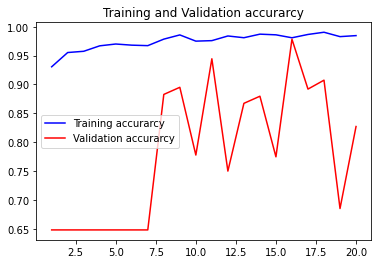

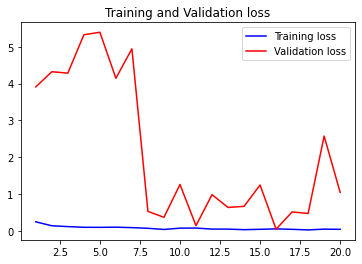

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
108/108 [==============================] - 7s 61ms/step
Test Accuracy: 82.71604180335999


In [ ]:
print("[INFO] Saving model...")
#pickle.dump(model,open('cnn_model.pkl', 'wb'))
model.save('/content/gdrive/My Drive/Sih_hamara/potato/potato.h5')


[INFO] Saving model...


### USE THE CODE BELOW TO RUN THE MODEL ###

In [13]:
import tensorflow as tf
from tensorflow import keras
import cv2

model_new = tf.keras.models.load_model('/content/gdrive/My Drive/Sih_hamara/potato/potato.h5')

['Potato___Early_blight']


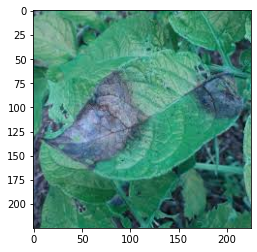

In [93]:
# test_img = cv2.imread('/content/gdrive/My Drive/Sih_hamara/potato/dataset/Potato/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG')
# test_img = cv2.imread('/content/gdrive/My Drive/Sih_hamara/potato/dataset/Potato/Potato___Potato_healthy/3edf7c3f-73e0-439c-870d-76cfd7c3bc45___RS_HL 1859.JPG')
test_img1 = cv2.imread('/content/gdrive/My Drive/Sih_hamara/potato/blight_potato.JPG')
plt.imshow(test_img1)



test_img1 = cv2.resize(test_img1,(256,256))
test_img1 = np.reshape(test_img1,[1,256,256,3])

# test_img = test_img / 255
# test_img = np.expand_dims(test_img, axis=0)
# pr=model_new.predict(test_img)

pr=model_new.predict(test_img1)
# print(pr)



output = label_binarizer.inverse_transform(pr)
print(output)
